In [3]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/root_newton/bin/python
farshed.abdukhakimov
cn-09
/home/farshed.abdukhakimov/projects/root_newton


In [4]:
%load_ext autoreload
%autoreload 2

import os
import sys
import urllib.request
import datetime
from collections import defaultdict
from typing import Callable

# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

import numpy as np
import scipy
import torch
torch.set_default_dtype(torch.float64)

import matplotlib.pyplot as plt

from dotenv import load_dotenv
load_dotenv()

import utils
from losses import BaseOracle, LogisticRegressionLoss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
def train_loop(dataset_name: str, n_steps: int,
               optimizer, **optimizer_kwargs) -> dict: 
    
    np.random.seed(0)
    
    # dataset
    if dataset_name == "synthetic":
        train_data, train_target = utils.make_synthetic_binary_classification(1000, 100)
    else:
        train_data, train_target = utils.get_LIBSVM(dataset_name)
        from sklearn.preprocessing import normalize
        train_data = normalize(train_data, norm="l2", axis=1)
        
    
    # parameters
    w = np.zeros((train_data.shape[1]))
    optim = optimizer(params=w, **optimizer_kwargs)

    # oracle 
    loss_function = LogisticRegressionLoss(train_data, train_target, lmd=1e-10)
    
    # e.g. libsvm dataset has {0.0, 1.0} classes that cannot be used for LogisticRegressionLoss 
    # hence they will be remapped to {-1.0, 1.0}
    if isinstance(loss_function, LogisticRegressionLoss):
        train_target = utils.map_classes_to(train_target, [-1.0, 1.0])
    
    
    # logging 
    history = defaultdict(list)
    
    start_timestamp = datetime.datetime.now()
        
    for step in range(n_steps):

        print(f"Step: [{step}/{n_steps}]")
        time = (datetime.datetime.now() - start_timestamp).total_seconds()
        loss = loss_function.func(w)
        grad = loss_function.grad(w)
        
        acc = (np.sign(train_data @ w) == train_target).sum() / train_target.shape[0]
        
        # optimization_step(params=w, oracle=loss_function, **optimization_step_kwargs)
        optim.step(oracle=loss_function)
        
        print(f"Loss: {loss} | GradNorm^2: {(np.linalg.norm(grad) ** 2 )} | Acc: {acc}")
        history["loss"].append(loss)
        history["grad_norm"].append(np.linalg.norm(grad) ** 2)
        history["accuracy"].append(acc)
        history["time"].append(time)
    
    return history

# Damped Newton


In [49]:
class BaseOptimizer(object):
    
    def step(self, params):
        raise NotImplementedError

class DampedNewton(BaseOptimizer):
    
    def __init__(self, params: np.ndarray, lr: float = 1.0):
        self.params = params
        self.lr = lr 
        
    def step(self, oracle: BaseOracle):
        
        grad = oracle.grad(self.params)
        hess = oracle.hess(self.params)
        n = np.linalg.solve(hess, grad)
        self.params -= self.lr * n
            
        return self.params

# Gradient Regularization of Newton Method
### Algorithm 1 in `Super-Universal Regularized Newton Method`

In [50]:
class GradRegNewton(BaseOptimizer):

    def __init__(self, params: np.ndarray, q: float = 2.0, L_est: float = 1.0):
        self.params = params
        self.q = q
        self.L_est = L_est
        
    def step(self, oracle):
        
        grad = oracle.grad(self.params)
        hess = oracle.hess(self.params)
        
        B = np.eye(self.params.shape[0])
        n = np.linalg.solve(hess, grad)
        g = np.sqrt(grad.dot(n))
        lambda_k = (6 * self.L_est * g**(self.q - 2))**(1 / (self.q - 1))
        try:
            # Compute the regularized Newton step
            delta_w = scipy.linalg.cho_solve(scipy.linalg.cho_factor(
                            hess + lambda_k * B, lower=False), -grad)
        except (np.linalg.LinAlgError, ValueError) as e:
            print('W: linalg_error', flush=True)
            
        self.params += delta_w
        
        return self.params

# AICN

In [51]:
class AICN(BaseOptimizer):
    
    def __init__(self, params: np.ndarray, L_est: float = 1.0):
        self.params = params
        self.L_est = L_est
        
    def step(self, oracle: BaseOracle):
        
        grad = oracle.grad(self.params)
        hess = oracle.hess(self.params)
        
        n = np.linalg.solve(hess, grad)
        g = np.sqrt(grad.dot(n))
        lr = (np.sqrt(1 + 2 * self.L_est * g) - 1) / (self.L_est * g)
        self.params -= lr * n

        return self.params

# Root Newton

Let $q = p + \nu$, where $q \in [2, 4]$ and $\nu \in [0, 1]$  
$p$ is a parameter for $p$-times differentiable function  
$\nu$ is a parameter for smoothness, i.e. smaller $\nu$ means greater smoothnees  

In [52]:
class RootNewton(BaseOptimizer):
    
    def __init__(self, params: np.ndarray, q: float, L_est: float = 1.0):
        self.params = params
        self.q = q
        self.L_est = L_est
        
    def step(self, oracle: BaseOracle):
        
        grad = oracle.grad(self.params)
        hess = oracle.hess(self.params)
        
        n = np.linalg.solve(hess, grad)
        g = np.sqrt(grad.dot(n))
        theta = (9 * self.L_est)**(1 / (self.q - 1)) * g**((self.q - 2) / (self.q - 1))
        lr = 1 / (1 + theta)
        self.params -= lr * n

        return self.params

# Simplified Regularization 

In [53]:
class SimpliReg(BaseOptimizer):
    
    def __init__(self, params: np.ndarray, beta: float, sigma: float):
        self.params = params
        self.beta = beta
        self.sigma = sigma
        
    def step(self, oracle: BaseOracle):
        
        grad = oracle.grad(self.params)
        hess = oracle.hess(self.params)
        
        n = np.linalg.solve(hess, grad)
        g = np.sqrt(grad.dot(n))
        theta = (self.sigma + 1) * g**self.beta
        lr = (1 / theta)**(1 / 1 + self.beta)
        
        self.params -= lr * n

        return self.params

Step: [0/30]
Loss: 0.6931471805599454 | GradNorm^2: 0.16975426525350082 | Acc: 0.0
Step: [1/30]
Loss: 0.30100740987691527 | GradNorm^2: 0.016261583933576147 | Acc: 0.963
Step: [2/30]
Loss: 0.18002611312694095 | GradNorm^2: 0.0028747571820715023 | Acc: 0.984
Step: [3/30]
Loss: 0.11017629740613825 | GradNorm^2: 0.0005578361106935666 | Acc: 0.994
Step: [4/30]
Loss: 0.06549434668351807 | GradNorm^2: 0.00011704357576948433 | Acc: 0.994
Step: [5/30]
Loss: 0.03657626448327995 | GradNorm^2: 2.586358845552531e-05 | Acc: 0.996
Step: [6/30]
Loss: 0.018252003807180762 | GradNorm^2: 5.1467067352300895e-06 | Acc: 1.0
Step: [7/30]
Loss: 0.007909085313177947 | GradNorm^2: 9.6034714952872e-07 | Acc: 1.0
Step: [8/30]
Loss: 0.00309361391883002 | GradNorm^2: 1.5346332016698868e-07 | Acc: 1.0
Step: [9/30]
Loss: 0.0011649527607955985 | GradNorm^2: 2.209461071377449e-08 | Acc: 1.0
Step: [10/30]
Loss: 0.00043465801681129827 | GradNorm^2: 3.091039894490986e-09 | Acc: 1.0
Step: [11/30]
Loss: 0.00016169048308461

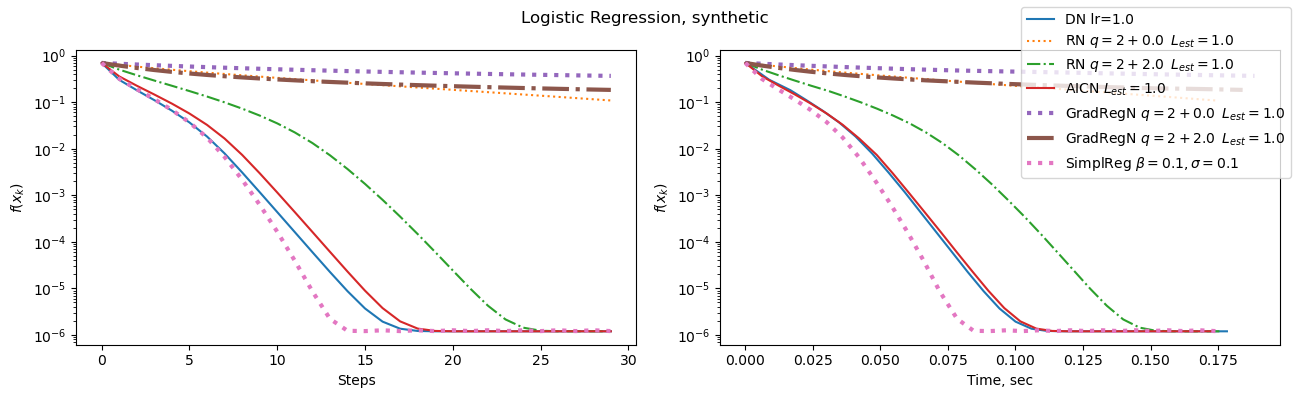

In [54]:
np.random.seed(0)

fig, ax = plt.subplots(1, 2, figsize=(13, 4))

n_steps = 30
dataset_name = "synthetic"

# Damped Newton
lr = 1.0
hist = train_loop(dataset_name=dataset_name, n_steps=n_steps, optimizer=DampedNewton, lr=lr)
ax[0].semilogy(hist["loss"])
ax[1].semilogy(hist["time"], hist["loss"], label=f"DN lr={lr}")

# Root Newton
for nu, ls in zip([0.0, 2.0], [":", "-."]):
    hist = train_loop(dataset_name=dataset_name, n_steps=n_steps, optimizer=RootNewton, q=2+nu, L_est=1.0)
    ax[0].semilogy(hist["loss"], linestyle=ls)
    ax[1].semilogy(hist["time"], hist["loss"], linestyle=ls, label=r"RN $q = 2 + {0} \;\; L_{{est}}=1.0$".format(nu))
    
        
# AICN
hist = train_loop(dataset_name=dataset_name, n_steps=n_steps, optimizer=AICN, L_est=1.0)
ax[0].semilogy(hist["loss"])
ax[1].semilogy(hist["time"], hist["loss"], label=r"AICN $L_{est}=1.0$")

# Gradient Regularization of Newton
for nu, ls in zip([0.0, 2.0], [":", "-."]):
    hist = train_loop(dataset_name=dataset_name, n_steps=n_steps, optimizer=GradRegNewton, q=2+nu, L_est=1.0)
    ax[0].semilogy(hist["loss"], linestyle=ls, linewidth=3.0)
    ax[1].semilogy(hist["time"], hist["loss"], linestyle=ls, linewidth=3.0, label=r"GradRegN $q = 2 + {0} \;\; L_{{est}}=1.0$".format(nu))

# Simplified Regularization
beta = 0.1
sigma = 0.1
hist = train_loop(dataset_name=dataset_name, n_steps=n_steps, optimizer=SimpliReg, beta=beta, sigma=sigma)
ax[0].semilogy(hist["loss"], linestyle=":", linewidth=3.0)
ax[1].semilogy(hist["time"], hist["loss"], linestyle=":", linewidth=3.0, label=r"SimplReg $\beta={}, \sigma={}$".format(beta, sigma))


plt.suptitle(f"Logistic Regression, {dataset_name}")
ax[0].set_ylabel(r"$f(x_k)$")
ax[0].set_xlabel("Steps")
ax[1].set_ylabel(r"$f(x_k)$")
ax[1].set_xlabel("Time, sec")

fig.legend()
fig.tight_layout()
fig.show()   

# Super Newton
### Algorithm 2 in `Super-Universal Regularized Newton Method`

In [55]:
class SuperNewton(BaseOptimizer):
    
    def __init__(self, params: np.ndarray, H_0: float = 1.0, 
                 alpha: float = 1.0, eps: float = 1e-8, H_min: float = 1e-5):
        self.params = params
        self.H_k = H_0
        self.H_min = H_min
        self.alpha = alpha
        self.eps = eps
        self.B = np.eye(params.shape[0])
        
        self.adaptive_search_max_iter = 40
        
    def step(self, oracle):
        
        grad = oracle.grad(self.params)
        hess = oracle.hess(self.params)
        
        grad_norm = grad.dot(grad) ** 0.5
        
        for i in range(self.adaptive_search_max_iter + 1):
            if i == self.adaptive_search_max_iter:
                print(('W: adaptive_iterations_exceeded'), flush=True)
                break

            lambda_k = self.H_k * grad_norm ** self.alpha
            try:
                # Compute the regularized Newton step
                delta_w = scipy.linalg.cho_solve(scipy.linalg.cho_factor(
                                hess + lambda_k * self.B, lower=False), -grad)
            except (np.linalg.LinAlgError, ValueError) as e:
                print('W: linalg_error', flush=True)

            loss_new = oracle.func(self.params + delta_w)
            grad_new = oracle.grad(self.params + delta_w)
            grad_norm_new_sqrd = grad_new.dot(grad_new) # squared norm of gradient at (w + delta_w) 

            # Check condition for H_k
            if grad_new.dot(-delta_w) >= grad_norm_new_sqrd / (4 * lambda_k):
                self.H_k *= 0.25
                self.H_k = max(self.H_k, self.H_min)
                break
            
            self.H_k *= 4
            
        # Update the point
        self.params += delta_w
            
        return self.params
        

# UN: Universal Newton

In [78]:
class UniversalNewton(BaseOptimizer):
    
    def __init__(self, params: np.ndarray, beta: float = 1.0, sigma_0: float = 1.0, 
                 c: float = 1.0):
        
        self.params = params
        self.beta = beta
        self.sigma_k = sigma_0
        self.c = c
        
        self.adaptive_search_max_iter = 40
        
    def step(self, oracle):
        
        grad = oracle.grad(self.params)
        hess = oracle.hess(self.params)
        
        n = np.linalg.solve(hess, grad)
        g = np.sqrt(grad.dot(n))
        
        for j in range(self.adaptive_search_max_iter + 1):
            if j == self.adaptive_search_max_iter:
                print(('W: adaptive_iterations_exceeded'), flush=True)
                break
            
            theta = self.c**j * self.sigma_k * g**self.beta
            alpha = 1 / (1 + theta)
            w_j = self.params - alpha * n

            # Check condition for H_k
            grad_new = oracle.grad(w_j)
            n_j = np.linalg.solve(hess, grad_new)
            g_j_sq = grad_new.dot(n_j)
            if grad_new.dot(n) >= g_j_sq / (2 * alpha * theta):
                self.sigma_k *= self.c**(j - 1)
                break
        
        # Update the parameters
        print(f"{alpha=}")
        self.params -= alpha * n
            
        return self.params
        

Step: [0/30]
Loss: 0.6931471805599454 | GradNorm^2: 0.16975426525350082 | Acc: 0.0
Step: [1/30]
Loss: 0.30100740987691527 | GradNorm^2: 0.016261583933576147 | Acc: 0.963
Step: [2/30]
Loss: 0.18002611312694095 | GradNorm^2: 0.0028747571820715023 | Acc: 0.984
Step: [3/30]
Loss: 0.11017629740613825 | GradNorm^2: 0.0005578361106935666 | Acc: 0.994
Step: [4/30]
Loss: 0.06549434668351807 | GradNorm^2: 0.00011704357576948433 | Acc: 0.994
Step: [5/30]
Loss: 0.03657626448327995 | GradNorm^2: 2.586358845552531e-05 | Acc: 0.996
Step: [6/30]
Loss: 0.018252003807180762 | GradNorm^2: 5.1467067352300895e-06 | Acc: 1.0
Step: [7/30]
Loss: 0.007909085313177947 | GradNorm^2: 9.6034714952872e-07 | Acc: 1.0
Step: [8/30]
Loss: 0.00309361391883002 | GradNorm^2: 1.5346332016698868e-07 | Acc: 1.0
Step: [9/30]
Loss: 0.0011649527607955985 | GradNorm^2: 2.209461071377449e-08 | Acc: 1.0
Step: [10/30]
Loss: 0.00043465801681129827 | GradNorm^2: 3.091039894490986e-09 | Acc: 1.0
Step: [11/30]
Loss: 0.00016169048308461

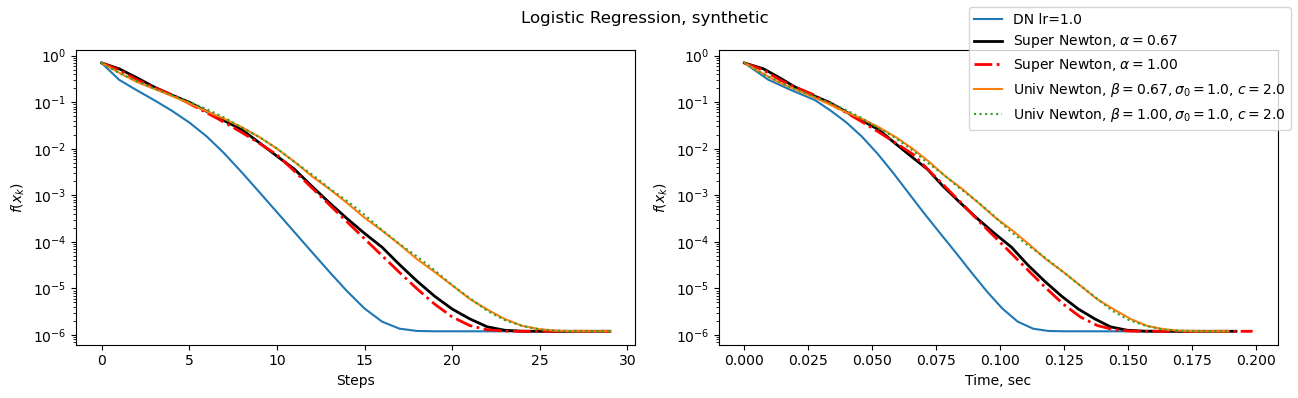

In [83]:
np.random.seed(0)

fig, ax = plt.subplots(1, 2, figsize=(13, 4))

n_steps = 30
dataset_name = "synthetic"

# Damped Newton
lr = 1.0
hist = train_loop(dataset_name=dataset_name, n_steps=n_steps, optimizer=DampedNewton, lr=lr)
ax[0].semilogy(hist["loss"])
ax[1].semilogy(hist["time"], hist["loss"], label=f"DN lr={lr}")

# Super Newton
for alpha, ls, color in zip([2/3, 1.0], ["-", "-."], ["black", "red"]):    
    hist = train_loop(dataset_name=dataset_name, n_steps=n_steps, optimizer=SuperNewton, alpha=alpha)
    ax[0].semilogy(hist["loss"], linestyle=ls, linewidth=2.0, color=color)
    ax[1].semilogy(hist["time"], hist["loss"], linestyle=ls, linewidth=2.0, color=color, label=r"Super Newton, $\alpha={0:.2f}$".format(alpha))


# Universal Newton
sigma_0 = 1.0
c = 2.0
for beta, ls in zip([2/3, 1.0], ["-", ":"]):
    hist = train_loop(dataset_name=dataset_name, n_steps=n_steps, optimizer=UniversalNewton, beta=beta, sigma_0=sigma_0, c=c)
    ax[0].semilogy(hist["loss"], linestyle=ls)
    ax[1].semilogy(hist["time"], hist["loss"], linestyle=ls, label=r"Univ Newton, $\beta={0:.2f}, \sigma_0={1}$, $c={2}$".format(beta, sigma_0, c))


plt.suptitle(f"Logistic Regression, {dataset_name}")
ax[0].set_ylabel(r"$f(x_k)$")
ax[0].set_xlabel("Steps")
ax[1].set_ylabel(r"$f(x_k)$")
ax[1].set_xlabel("Time, sec")

fig.legend()
fig.tight_layout()
fig.show()   